
# Churn model development

### Table of Contents

1. [Dependencies](#Dependencies)
2. [Data cleaning](#Datacleaning)
3. [Pre-processing](#Pre-processing)
4. [Model pipeline](#Modelpipeline)
5. [Fit model pipeline](#fitmodelpipeline)
   - [Fit to F1 score](#fittof1score)
   - [Fit to profit metric](#fittoprofitmetric)

### 1. Dependencies <a class="anchor" id="Dependencies"></a>

In [1]:
# Import dependencies
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Model and data processing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, MinMaxScaler

# Model and pipeline build

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model validation
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer

# save model
import joblib



### 2. Data cleaning <a class="anchor" id="Datacleaning"></a>

In [2]:
# Read in data
df =pd.read_csv('../01 Data/raw__churn_challenge__20210821.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
# Convert Total Charges to a numeric data type and confirm
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors = 'coerce')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [7]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### 3. Pre-processing <a class="anchor" id="Pre-processing"></a>

In [8]:
# Remove missing values 
# Missing values account for a small proportion of total values 
df.dropna(inplace = True)
# Remove customer IDs from the data set
df2 = df.iloc[:,1:]

In [9]:
# Convert the predictor variable in to a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [10]:
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [11]:
#Convert all categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [12]:
# split into x_train and x_val
X_train = df_dummies.drop(['Churn'], axis=1)
y_train = df_dummies['Churn']

In [13]:
# This isn't a massive dataset so use a larger split, also need to stratify by churn
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=.30)

In [14]:
# Develop folds for Kfold testing, make sure folds are stratified by churn, use constant seed to allow repeatable results
n_folds = 10
seed = 3
kfold = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)

### 4. Model pipeline <a class="anchor" id="Modelpipeline"></a>

In [15]:
# Build classifier pipeline using a 
clfs = []

clfs.append(("LogReg", 
             Pipeline([("Scaler", MinMaxScaler()),
                       ("LogReg", LogisticRegression(penalty = 'l2', class_weight = 'balanced'))])))

clfs.append(("GaussianNB", 
             Pipeline([("Scaler", MinMaxScaler()),
                       ("GaussianNB", GaussianNB())])))

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", MinMaxScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", MinMaxScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", MinMaxScaler()),
                       ("XGB", XGBClassifier())])))

### 5. Fit model pipeline <a class="anchor" id="fitmodelpipeline"></a>

####  Fit to F1 score <a class="anchor" id="fittof1score"></a>

In [16]:
dff1 = pd.DataFrame(columns = ['model', 'metric', 'f1'], index = None)
df_temp = pd.DataFrame(columns = ['model', 'metric', 'f1'], index = None)
results, names  = [], []
score = 'f1'

# Fit each model using k-fold validation and store results in dataframe
for name, model  in clfs:
    # get cross validation results
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=score, n_jobs=-1)
    
    
    # store results in temporary dataframe
    df_temp = pd.DataFrame([[score, 'f1', name] for score in cv_results],
                           columns = ['f1','metric', 'model'])
    
    dff1 = pd.concat([dff1, df_temp], ignore_index = True)   
    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)

LogReg: 0.624437 (+/- 0.017033)
GaussianNB: 0.591128 (+/- 0.011519)
DecisionTreeClassifier: 0.495030 (+/- 0.044067)
RandomForestClassifier: 0.538231 (+/- 0.046808)
XGBClassifier: 0.532291 (+/- 0.038965)


In [17]:
dff1.head()

,model,metric,f1
0,LogReg,f1,0.600601
1,LogReg,f1,0.614925
2,LogReg,f1,0.636364
3,LogReg,f1,0.612613
4,LogReg,f1,0.619469


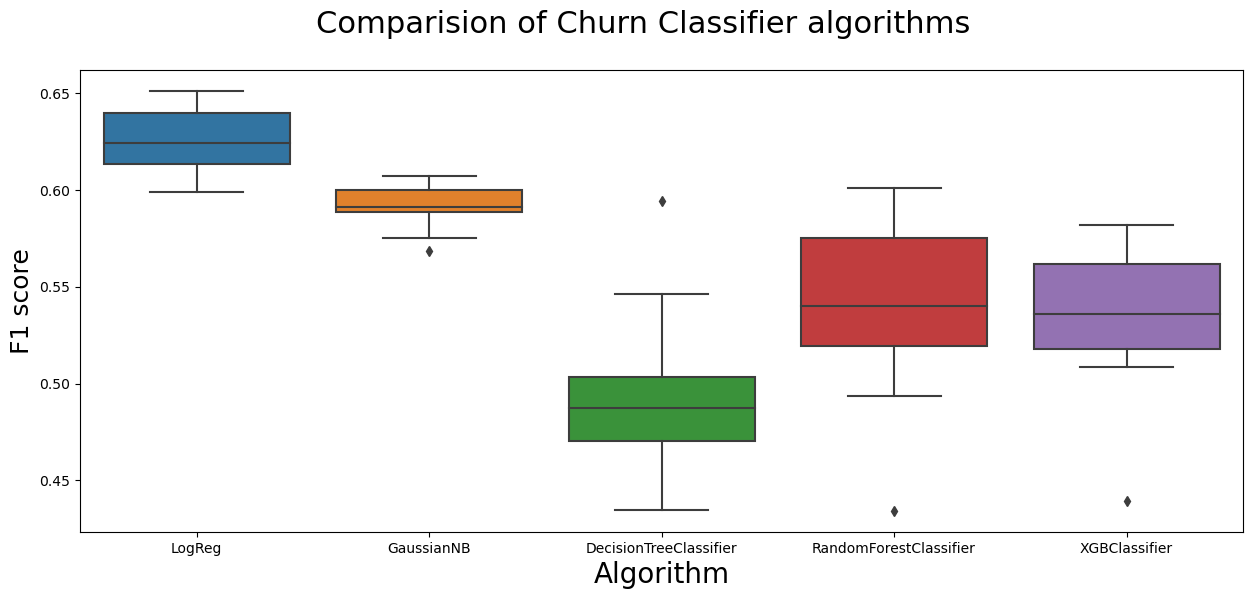

In [18]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Comparision of Churn Classifier algorithms', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x='model', y='f1', data=dff1)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=20)
ax.set_ylabel("F1 score", fontsize=18)
ax.set_xticklabels(dff1['model'].unique().tolist())

plt.show()

####  Fit to Profit Metric <a class="anchor" id="fittoprofitmetric"></a>

In [19]:
# Create a profit metric
# Customers that are predicted to churn can be incentivised to remain loyal
# Spending money on predicted churn customers can lead to increased profit 
def profit_metric(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (5000-1000), 0)
    fp = np.where((y_pred==1) & (y==0), -1000, 0)
    return np.sum([tp,fp])
pf_met = make_scorer(profit_metric, greater_is_better=True)

In [20]:
dfprf = pd.DataFrame(columns = ['model', 'metric', 'Profit'], index = None)
df_temp = pd.DataFrame(columns = ['model', 'metric', 'Profit'], index = None)
results, names  = [], []
n_folds = 10

# Fit each model using k-fold validation and store results in dataframe
for name, model  in clfs:
    # Fit each model using k-fold validation and store results in dataframe
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=pf_met, n_jobs=-1)
    
    
    # store results in temporary dataframe
    df_temp = pd.DataFrame([[score, 'Profit', name] for score in cv_results],
                           columns = ['Profit','metric', 'model'])
    
    dfprf = pd.concat([dfprf, df_temp], ignore_index = True)  
    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)

LogReg: 319600.000000 (+/- 16734.395717)
GaussianNB: 307400.000000 (+/- 12483.589227)
DecisionTreeClassifier: 191900.000000 (+/- 30940.103426)
RandomForestClassifier: 212500.000000 (+/- 27034.237552)
XGBClassifier: 210600.000000 (+/- 25188.092425)


<ipython-input-21-e32ae8ba307f>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


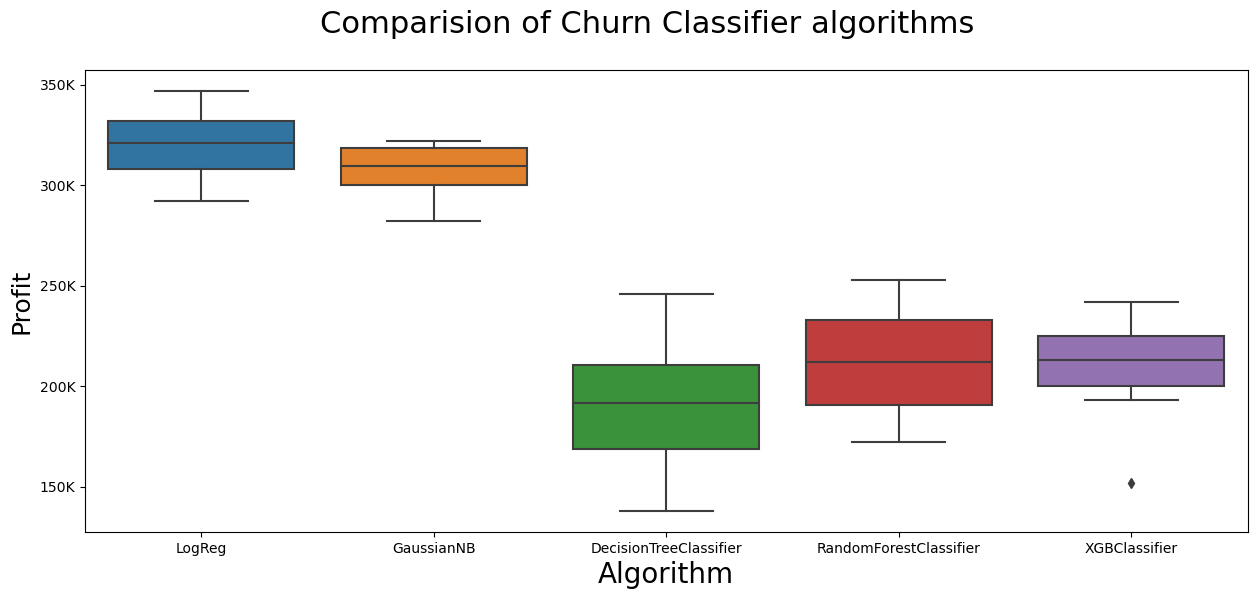

In [21]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Comparision of Churn Classifier algorithms', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x='model', y='Profit', data=dfprf)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithm", fontsize=20)
ax.set_ylabel("Profit", fontsize=18)
ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
ax.set_xticklabels(dfprf['model'].unique().tolist())

plt.show()